# Module 3: Deep Learning with Keras
David John Gagne,
National Center for Atmospheric Research

## Goals of this Module
* Learn the definition of deep learning and how it differs from traditional machine learning approaches
* Understand what Keras is, how it works, and how it interfaces with other deep learning libraries
* Build a densely-connected neural network in Keras
* Discover how the choice of activation function affects performance
* Build a convolutional neural network in Keras and see how it performs compared with the dense neural network
* See how data are transformed by passing through convolutional layers

## Software Requirements
This module requires the following software libraries:
* Python 3.6 or higher
* Numpy
* Pandas
* Matplotlib
* IPython
* Jupyter
* Xarray
* netCDF4
* Tensorflow (GPU version recommended for training convolutional neural networks)
* Keras
* CUDA 9.2 or higher and cuDNN (for interfacing with NVIDIA GPU)

## What is Deep Learning?
![ai_ml_dl](ai_ml_dl_diagram.png)
Deep learning should be defined in the context of Artificial Intelligence and Machine Learning. 
* **Artificial Intelligence (AI)**: the many ways for computers to perform cognitive tasks traditionally accomplished by humans without direct control from humans.  
* Historically, there have been two schools of thought for developing AI systems.
    * **Expert Systems**: an expert at a task creates algorithms and rules that describe how a task is done, and then the AI program accomplishes the task based on the rules.
        * Often implemented as Fuzzy Logic
        * Operational Examples: NEXRAD Hydrometeor Classification Algorithm, Method for Object-based Diagnostic Evaluation (MODE)
        * Pros: Requires no data, interpretable, manipulatable
        * Cons: Brittle algorithms, complexity hard to manage, not adaptive
    * **Machine Learning (ML)**: mathematical models with a specified structure that learn to perform tasks from data
        * Common algorithms: Neural networks, decision trees, support vector machines
        * Pros: Potentially high predictive skill, can learn complex patterns and relationships, quantify uncertainty, interpretable
        * Cons: Requires large amounts of data, extensive pre-processing of features, extrapolation issues
* **Deep Learning**: A subset of machine learning consisting of neural networks with many specialized hidden layers for encoding structural patterns in input data to produce better predictions
    * Common algorithms: convolutional neural networks, recurrent neural networks
    * Pros: Increased predictive skill over traditional ML on image and time-series problems, less pre-processing and feature engineering required
    * Cons: Requires more data and computational resources than traditional machine learning, harder to train well, greater sensitivity to adversarial data

## What is Keras?
![power_rankings](https://cdn-images-1.medium.com/max/1600/1*s_BwkYxpGv34vjOHi8tDzg.png)
Keras is a human-centered high-level API for deep learning. Keras provides an object-oriented interface for creating neural networks of arbitrary complexity by connecting layers together in different ways. Because Keras is meant to be an interface rather than a full-fledged deep learning library, it has been implemented on top of multiple deep learning libraries and in other programming languages. Keras serves as the official high-level API for Tensorflow and can also interface with Theano and Microsoft's CNTK.  There is also an R interface for Keras.

Kera uses a hierarchical object representation for its neural networks. A full network is stored as a Model object, which contains a list of layers that can be connected either sequentially or arbitrarily. Each layer is its own object and contains a name and parameters, including weights and settings. For training and inference, Keras implements the scikit-learn fit and predict API but also offers low-level ways to call the model and its individual components. The keras backend offers ways to pass data through aribitrary subsets of the model, which will enable us to see how neural networks transform data to make predictions.

## Data Processing

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, expanduser
from sklearn.preprocessing import StandardScaler
from ipywidgets import interact
import ipywidgets as widgets
from keras.models import Model, save_model, load_model
from keras.layers import Dense, Activation, Conv2D, Input, AveragePooling2D, MaxPooling2D, Flatten, LeakyReLU, Dropout
from keras.layers import SpatialDropout2D
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import keras.backend as K
from scipy.ndimage import gaussian_filter
from sklearn.metrics import mean_squared_error, roc_auc_score

Using TensorFlow backend.


First we will load the csv data files needed to train the network and concatenate them together.

In [2]:
csv_path = "../data/track_data_ncar_ams_3km_csv_small/"
csv_files = sorted(glob(join(csv_path, "*.csv")))
csv_data_list = []
for csv_file in csv_files:
    print(csv_file)
    csv_data_list.append(pd.read_csv(csv_file))
csv_data = pd.concat(csv_data_list, ignore_index=True)
del csv_data_list

../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv
../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv
../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv
../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv
../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv
../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv
../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv
../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv
../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110425-0000.csv
../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110509-0000.csv
../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110522-0000.csv
../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d0

In [11]:
csv_data.columns

Index(['Step_ID', 'Track_ID', 'Ensemble_Name', 'Ensemble_Member', 'Run_Date',
       'Valid_Date', 'Forecast_Hour', 'Valid_Hour_UTC', 'Duration',
       'Centroid_Lon', 'Centroid_Lat', 'Centroid_X', 'Centroid_Y',
       'Storm_Motion_U', 'Storm_Motion_V', 'REFL_COM_mean', 'REFL_COM_max',
       'REFL_COM_min', 'REFL_COM_std', 'REFL_COM_percentile_10',
       'REFL_COM_percentile_25', 'REFL_COM_percentile_50',
       'REFL_COM_percentile_75', 'REFL_COM_percentile_90', 'U10_mean',
       'U10_max', 'U10_min', 'U10_std', 'U10_percentile_10',
       'U10_percentile_25', 'U10_percentile_50', 'U10_percentile_75',
       'U10_percentile_90', 'V10_mean', 'V10_max', 'V10_min', 'V10_std',
       'V10_percentile_10', 'V10_percentile_25', 'V10_percentile_50',
       'V10_percentile_75', 'V10_percentile_90', 'T2_mean', 'T2_max', 'T2_min',
       'T2_std', 'T2_percentile_10', 'T2_percentile_25', 'T2_percentile_50',
       'T2_percentile_75', 'T2_percentile_90', 'RVORT1_MAX-future_mean',
       'RVOR

We will pick a set of input variables and an output field, split the data based on a single date, and pull out the strong rotation cases.

In [3]:
# input variables
input_columns = ["REFL_COM_mean", "U10_mean", "V10_mean", "T2_mean"]
output_column = "RVORT1_MAX-future_max"
# vorticity threshold in s-1
out_threshold = 0.005
train_test_date = pd.Timestamp("2015-01-01")
valid_dates = pd.DatetimeIndex(csv_data["Valid_Date"])
# Extract the input training data to the neural network
train_data = csv_data.loc[valid_dates < train_test_date, input_columns]
# Label strong rotation as 1 and weak or no rotation as 0
train_out = np.where(csv_data.loc[valid_dates < train_test_date, output_column] > out_threshold, 1, 0)
# 
test_data = csv_data.loc[valid_dates >= train_test_date, input_columns]
test_out = np.where(csv_data.loc[valid_dates >= train_test_date, output_column] > out_threshold, 1, 0)
print(f"Training strong rotation examples: {100 * train_out.sum() / train_out.size: 0.3f}%")
print(f"Training strong rotation example: {100 * test_out.sum() / test_out.size: 0.3f}%")

Training strong rotation examples:  4.552%
Training strong rotation example:  5.266%


We will use a standard scaler to normalize the input data for the neural network. 

In [4]:
scaler = StandardScaler()
train_norm = scaler.fit_transform(train_data)
test_norm = scaler.transform(test_data)
for i, input_col in enumerate(input_columns):
    print(f"{input_columns[i]:13s} Mean: {scaler.mean_[i]:0.3f} SD: {scaler.scale_[i]:0.3f}")

REFL_COM_mean Mean: 46.847 SD: 3.984
U10_mean      Mean: 0.450 SD: 4.348
V10_mean      Mean: 0.543 SD: 4.462
T2_mean       Mean: 289.409 SD: 6.932


For the convolutional neural network, we will load the spatial patches centered on each storm.

In [5]:
# Create a list of storm netCDF4 files. If the files are not in your home directory,
# Change the start_path variable to the appropriate location
start_path = join(expanduser("~"), "ams-ml-python-course")
storm_files = sorted(glob(join(start_path, "data/track_data_ncar_ams_3km_nc_small/*.nc")))
print(storm_files[0])
run_times = []
valid_times = []
# List of input variables
in_vars = ["REFL_COM_curr",
           "U10_curr", "V10_curr"]
# List of output variables
out_vars = ["RVORT1_MAX_future"]
in_data = []
out_data = []
# Loop through each storm file and extract the relevant variables
for storm_file in storm_files:
    # Extract run time from the filename
    run_time = pd.Timestamp(storm_file.split("/")[-1].split("_")[1])
    # If you want to ignore certain run_dates, encapsulate the remaining lines in an if statement
    ds = xr.open_dataset(storm_file)
    # Stack the variables in the order listed within a given file
    in_data.append(np.stack([ds[v].values for v in in_vars], axis=-1))
    out_data.append(np.stack([ds[v].values for v in out_vars], axis=-1))
    # Extract the valid times
    valid_times.append(ds["time"].values)
    # Extract the run times and match each run time with each patch
    run_times.append([run_time] * in_data[-1].shape[0])
    print(run_time)
    ds.close()
# Stack the  data into single arrays instead of lists of arrays
all_in_data = np.vstack(in_data)
all_out_data = np.vstack(out_data)
all_run_times = np.concatenate(run_times)
all_valid_times = np.concatenate(valid_times)
# Deallocate the lists of arrays to save memory
del in_data[:], out_data[:], run_times[:], valid_times[:]
del in_data, out_data, run_times, valid_times

/home/jovyan/ams-ml-python-course/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc
2010-10-24 00:00:00
2010-11-22 00:00:00
2011-02-01 00:00:00
2011-03-08 00:00:00
2011-03-26 00:00:00
2011-04-04 00:00:00
2011-04-14 00:00:00
2011-04-20 00:00:00
2011-04-25 00:00:00
2011-05-09 00:00:00
2011-05-22 00:00:00
2011-05-27 00:00:00
2011-06-05 00:00:00
2011-06-10 00:00:00
2011-06-15 00:00:00
2011-06-20 00:00:00
2011-06-25 00:00:00
2011-07-04 00:00:00
2011-07-12 00:00:00
2011-11-16 00:00:00
2012-02-18 00:00:00
2012-03-15 00:00:00
2012-03-23 00:00:00
2012-04-01 00:00:00
2012-04-09 00:00:00
2012-04-26 00:00:00
2012-05-03 00:00:00
2012-05-10 00:00:00
2012-05-29 00:00:00
2012-06-06 00:00:00
2012-06-22 00:00:00
2012-07-01 00:00:00
2012-07-06 00:00:00
2012-07-15 00:00:00
2012-12-25 00:00:00
2013-03-18 00:00:00
2013-03-31 00:00:00
2013-04-11 00:00:00
2013-04-29 00:00:00
2013-05-13 00:00:00
2013-05-19 00:00:00
2013-05-27 00:00:00
2013-06-02 00:00:00
2013-06-13 00:00:00
201

Once we load the netCDF data, we also need to normalize each input variable. To do so, we calculate the mean and standard deviation across all grid points for a given variable and use that to re-scale the data.

In [6]:
def normalize_multivariate_data(data, scaling_values=None):
    """
    Normalize each channel in the 4 dimensional data matrix independently.

    Args:
        data: 4-dimensional array with dimensions (example, y, x, channel/variable)
        scaling_values: pandas dataframe containing mean and std columns

    Returns:
        normalized data array, scaling_values
    """
    normed_data = np.zeros(data.shape, dtype=data.dtype)
    scale_cols = ["mean", "std"]
    if scaling_values is None:
        scaling_values = pd.DataFrame(np.zeros((data.shape[-1], len(scale_cols)), dtype=np.float32),
                                      columns=scale_cols)
    for i in range(data.shape[-1]):
        scaling_values.loc[i, ["mean", "std"]] = [data[:, :, :, i].mean(), data[:, :, :, i].std()]
        normed_data[:, :, :, i] = (data[:, :, :, i] - scaling_values.loc[i, "mean"]) / scaling_values.loc[i, "std"]
    return normed_data, scaling_values

In [7]:
train_norm_2d, scaling_values = normalize_multivariate_data(all_in_data[valid_dates < train_test_date])
test_norm_2d, _ = normalize_multivariate_data(all_in_data[valid_dates >= train_test_date], scaling_values=scaling_values)
print(scaling_values)

        mean        std
0  22.437183  15.817961
1  -0.619780   4.428548
2   0.313597   5.116556


## Dense Neural Networks
![neuralnet](http://cs231n.github.io/assets/nn1/neural_net2.jpeg)
An artificial neural network is a machine learning algorithm that can nonlinearly transform a set of inputs into one or more outputs. Artificial neural networks are vaguely inspired by how a neuron in the brain works, but they are not explicitly modeling the brain. A neural network consists of an input layer, one or more hidden layers, and an output layer. The hidden layers perform a transformation on the output of the previous layer, and the output layer transforms the hidden representation into a prediction. Each layer consists of a set of perceptrons, or artificial neurons.
![neuron](http://cs231n.github.io/assets/nn1/neuron_model.jpeg)
Inside each neuron is a set of weights associated with each input to the neuron and an additive bias term. Essentially, this part is a linear regression. The inputs are multiplied by the weights and summed together. Then the sum is passed through an activation function, which transforms the data in some nonlinear way. Often the goal of the activation function is to either add sparsity to the representation by setting some of the neurons to 0 or to restrict the range of possible values. Activations are generally used directly after dense or convolutional layers in the network.

A set of common activation functions and their gradients, or derivatives, is plotted below.

Text(0.5, 1.0, 'ANN Activation Gradients')

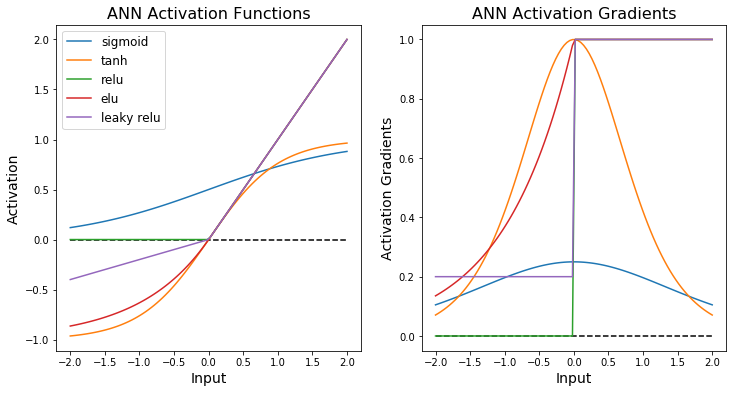

In [8]:
# Placeholder input tensor allows for numpy arrays to be fed through the function into Tensorflow
act_in = K.placeholder()
# List of activations
activations = ["sigmoid", "tanh", "relu", "elu"]
act_funcs = []
in_vals = np.linspace(-2, 2, 100)
out_vals = []
plt.figure(figsize=(12, 6))
# Plot each activation function
plt.subplot(1, 2, 1)
plt.plot(in_vals, np.zeros(in_vals.shape), 'k--')
for act in activations:
    # K.function creates a general input-output function between 2 connected keras tensors
    act_funcs.append(K.function([act_in], [Activation(act)(act_in)]))
    out_vals.append(act_funcs[-1]([in_vals])[0])
    plt.plot(in_vals, out_vals[-1], label=act)
act_funcs.append(K.function([act_in], [LeakyReLU(0.2)(act_in)]))
out_vals.append(act_funcs[-1]([in_vals])[0])
plt.plot(in_vals, out_vals[-1], label="leaky relu")
plt.xlabel("Input", fontsize=14)
plt.ylabel("Activation", fontsize=14)
plt.title("ANN Activation Functions", fontsize=16)
plt.legend(fontsize=12)
plt.subplot(1, 2, 2)
# Plot the gradients of each activation function
plt.plot(in_vals, np.zeros(in_vals.shape), 'k--')
for act in activations:
    # K.gradients calculates the gradient between an arbitrary input and output pairing
    act_funcs.append(K.function([act_in], K.gradients(Activation(act)(act_in), act_in)))
    out_vals.append(act_funcs[-1]([in_vals])[0])
    plt.plot(in_vals, out_vals[-1], label=act)
act_funcs.append(K.function([act_in], K.gradients(LeakyReLU(0.2)(act_in), act_in)))
out_vals.append(act_funcs[-1]([in_vals])[0])
plt.plot(in_vals, out_vals[-1], label="leaky relu")
plt.xlabel("Input", fontsize=14)
plt.ylabel("Activation Gradients", fontsize=14)
plt.title("ANN Activation Gradients", fontsize=16)

Common activation functions are plotted above. Classical ANNs used a sigmoid or hyperbolic tangent (tanh) activation function to mimic the activation of neurons in the brain. The problem with sigmoids, and to a lesser extent with tanh, is that when error information is backpropagated through the network, the maximum gradient (derivative of input with respect to change in output) of the sigmoid is around 0.3, so each backward pass through a sigmoid reduces the magnitude of the gradient by 70% or more. This leads to the "vanishing gradient problem" for deep neural networks. After 2 or 3 layers the magnitude of the gradient is too small to provide a consistent signal about how the weights should be updated, resulting in poor convergence of the model.

The Rectifed Linear Unit (ReLU) activation solves this issue by performing a transform such that positive values retain their original magnitude while negative values are set to 0. Because the magnitude of the positive gradient does not decrease, the gradient signal can be propagated through many layers without vanishing. Zeroing out the negative gradient can sometimes lead to dead neurons, so variants of the ReLU, such as the Leaky ReLU and the Exponential Linear Unit (ELU) have been created to propagate negative information but at a reduced magnitude.

## Neural Network Training
The weights of a neural network are optimized through the process of stochastic gradient descent. 
1. A batch, or random subset of the training data, is sent through the neural network to generate predictions. 

2. Those predictions are compared with the true labels or values through the use of a loss or error function. A common error function for regression is mean squared error. Since the mean squared error is equivalent to the Brier Score, it can also be used for binary classification problems. Another common loss function for classification is cross-entropy, which is $y\log{(p)} + (1-y)\log{(1-p)}$ where y is either 1 or 0 and p is the predicted probability.

3. The derivative of the error with respect to each weight in the network ($\frac{dL}{dw}$) is calculated. The derivative of a given weight in the network depends on the derivatives of the weights of any neurons between a given neuron and the output layer, so those derivatives must be calculated first. This process is called back-propagation.

4. Once the derivative is calculated for a given weight, the weight is updated by subtracting a fraction of the derivative from the original weight $\theta=\theta-\epsilon \hat{\frac{dL}{d\theta}}$. The fraction $\epsilon$ is called the learning rate. The process of optimization by stepping against the gradient is called gradient descent. When performed on a random subset of the training data instead of all of the training data, the process is called stochastic gradient descent.

A larger learning rate results in faster convergence, but too large a learning rate can cause the optimizer to overshoot the global minimum. If the learning rate is too small, the optimizer can get trapped in a local minimum or just never converge. Specialized optimizer functions have been developed to address some of these issues.

SGD: Stochastic Gradient Descent. The stochastic component comes from selecting a random "batch" of training examples for each update. SGD includes an option to add momentum to the gradient descent update, which allows the optimizer to retain a memory of what the previous gradients were to reduce the variance in stochastic gradient computations. A high momentum value around 0.99 is generally recommended in practice.

Adam: Short for "adaptive moments." This optimizer automatically updates the learning rate based on the first and second moments of the gradient. The key parameters are `beta_1` and `beta_2`, which default to 0.9 and 0.99 respectively. I have had some success setting the learning rate and beta_1 to lower values, but the default values work well.

Now we will train a simple 1-layer neural network to predict the probability of strong rotation. 

In [9]:
# set the batch size 
batch_size = 128
# an epoch is one pass through the training data
num_epochs = 10
# number of neurons in the hidden layer
hidden_neurons = 10
# learning rate
learning_rate = 0.01
# Set the optimizer to SGD or change it to an Adam object
optimizer = SGD(lr=learning_rate, momentum=0.9)
# loss can be binary_crossentropy or mse
loss = "binary_crossentropy"
# Create an input layer
small_net_input = Input(shape=(len(input_columns),))
# Hidden layer with a hyperbolic tangent (tanh) activation function
small_net_hidden = Dense(hidden_neurons, activation="tanh")(small_net_input)
# Output layers with a sigmoid activation function
small_net_out = Dense(1, activation="sigmoid")(small_net_hidden)
# combine the layers into a model object
small_model = Model(small_net_input, small_net_out)
# compile the model object to instantiate all the tensorflow connections
small_model.compile(optimizer, loss=loss)
# The batch size should be divisible by the number of training examples. 
# We will subject the remainder to ensure this
batch_diff = train_norm.shape[0] % batch_size
# Create training indices for random batch sampling later
batch_indices = np.arange(train_norm.shape[0] - batch_diff)
num_batches = int(batch_indices.size / batch_size)
# Extract the weights from the network
# hw = hidden weights, hb = hidden bias, ow = output weights ,ob = output bias
hw, hb, ow, ob = small_model.get_weights()
# Store the values of the hidden and output weights after each batch
hw_series = np.zeros([num_batches * num_epochs] + list(hw.shape))
ow_series = np.zeros([num_batches * num_epochs] + list(ow.shape))
i = 0
# Each epoch is one pass through the training data
for e in range(num_epochs):
    print(e)
    # At the beginning of each epoch, shuffle the order of the training examples
    batch_indices = np.random.permutation(batch_indices)
    for b in range(num_batches):
        hw_series[i], hb, ow_series[i], ob = small_model.get_weights()
        # Perform one update based on a batch of training data
        small_model.train_on_batch(train_norm[batch_indices[b * batch_size: (b + 1) * batch_size]],
                                   train_out[batch_indices[b * batch_size: (b + 1) * batch_size]])
        
        i += 1

0
1
2
3
4
5
6
7
8
9


Here is a summary of the neural network model we just trained.

In [63]:
small_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


Now we will plot how the neural network weights changed. Notice how all weights start in random locations but some weights undergo significant evolution with time. Go back and retrain the network with a different learning rate or batch size. How does that change the trajectory of the weights?

Text(0.5, 1.0, 'Output Layer Weights Optimized')

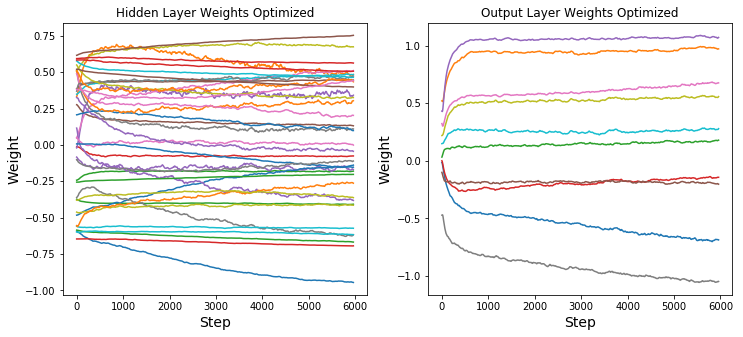

In [10]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
hw_flat = hw_series.reshape(hw_series.shape[0], hw_series.shape[1] * hw_series.shape[2])
for i in range(hw_flat.shape[1]):
    plt.plot(hw_flat[:, i])
plt.xlabel("Step", fontsize=14)
plt.ylabel("Weight", fontsize=14)
plt.title("Hidden Layer Weights Optimized")
plt.subplot(1, 2, 2)
ow_flat = ow_series.reshape(ow_series.shape[0], ow_series.shape[1] * ow_series.shape[2])
for i in range(ow_flat.shape[1]):
    plt.plot(ow_flat[:, i])
plt.xlabel("Step", fontsize=14)
plt.ylabel("Weight", fontsize=14)
plt.title("Output Layer Weights Optimized")

We can also train the neural network by calling the fit method and specifying the number of epochs and the batch size.

In [138]:
small_model.fit(train_norm, train_out, epochs=10, batch_size=128)

Epoch 1/10
76377/76377 [==============================] - 0s 6us/step - loss: 0.0820
Epoch 2/10
76377/76377 [==============================] - 0s 6us/step - loss: 0.0819
Epoch 3/10
76377/76377 [==============================] - 0s 6us/step - loss: 0.0819
Epoch 4/10
76377/76377 [==============================] - 0s 6us/step - loss: 0.0819
Epoch 5/10
76377/76377 [==============================] - 0s 6us/step - loss: 0.0818
Epoch 6/10
76377/76377 [==============================] - 0s 6us/step - loss: 0.0818
Epoch 7/10
76377/76377 [==============================] - 0s 6us/step - loss: 0.0818
Epoch 8/10
76377/76377 [==============================] - 0s 6us/step - loss: 0.0818
Epoch 9/10
76377/76377 [==============================] - 0s 6us/step - loss: 0.0818
Epoch 10/10
76377/76377 [==============================] - 0s 6us/step - loss: 0.0817


Now we will calculate a few verification scores to determine how well the neural network has performed. 

In [11]:
small_model_preds = small_model.predict(test_norm).ravel()
small_model_auc = roc_auc_score(test_out, small_model_preds)
small_model_brier_score = mean_squared_error(test_out, small_model_preds)
climo_brier_score = mean_squared_error(test_out, np.ones(test_out.size) * test_out.sum() / test_out.size)
small_model_brier_skill_score = 1 - small_model_brier_score / climo_brier_score
print(f"AUC: {small_model_auc:0.3f}")
print(f"Brier Score: {small_model_brier_score:0.3f}")
print(f"Brier Score (Climatology): {climo_brier_score:0.3f}")
print(f"Brier Skill Score: {small_model_brier_skill_score:0.3f}")

AUC: 0.884
Brier Score: 0.039
Brier Score (Climatology): 0.050
Brier Skill Score: 0.220


What happens to the data as it passes through the neural net? Below are static and interactive visualizations of the inside of a neural network given a set of input fields. The colored circles indicate value of a particular neuron. Red is positive and blue is negative. The colored lines show the weight assigned to each connection. Darker lines have larger weights. 

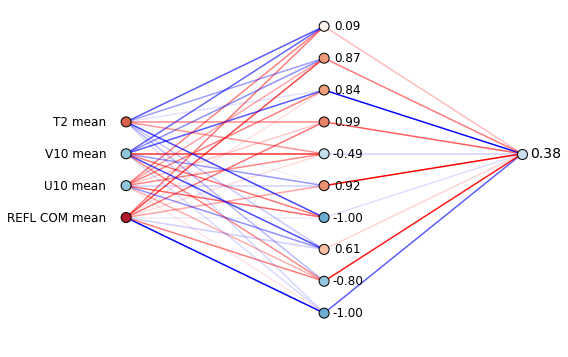

In [12]:
def plot_neural_net(refl, u10, v10, t2):
    plt.figure(figsize=(8, 6))
    nn_func = K.function([neural_net.input], [neural_net.layers[1].output, neural_net.layers[2].output])
    h1_out, out_out = nn_func([np.array([[refl, u10, v10, t2]])])
    h_weights = neural_net.layers[1].get_weights()[0]
    out_weights = neural_net.layers[2].get_weights()[0]
    plt.axis("off")
    i1 = 0
    for y1 in range(3, 7):
        plt.text(-0.1, y1, input_columns[i1].replace("_", " "), ha='right', va='center', fontsize=12)
        for y2 in range(0, 10):
            if h_weights[i1, y2] > 0:
                color = [1, 0, 0, np.abs(h_weights[i1, y2]) / np.abs(h_weights).max()]
            else:
                color = [0, 0, 1, np.abs(h_weights[i1, y2]) / np.abs(h_weights).max()]
            plt.plot([0, 1], [y1, y2], linestyle='-', 
                     color=color, zorder=0)
        i1 += 1
    for y2 in range(0, 10):
        if out_weights[y2, 0] > 0:
            color = (1, 0, 0, np.abs(out_weights[y2, 0] / np.abs(out_weights).max()))
        else:
            color = (0, 0, 1, np.abs(out_weights[y2, 0] / np.abs(out_weights).max()))
        plt.plot([1, 2], [y2, 5], linestyle='-',
                 color=color, zorder=0)
    plt.scatter(np.zeros(4), np.arange(3, 7), 100, np.array([refl, u10, v10, t2]),
                vmin=-5, vmax=5, cmap="RdBu_r", edgecolor='k', )
    plt.scatter(np.ones(h1_out.size), np.arange(h1_out.size), 100, h1_out.ravel(), 
                edgecolor='k', vmin=-2, vmax=2, cmap="RdBu_r")
    for i in range(10):
        plt.text(1.12, i, "{0:0.2f}".format(h1_out.ravel()[i]), ha='center', va='center', fontsize=12)
    plt.scatter([2], [5], [100], out_out[0], vmin=0, vmax=1, cmap="RdBu_r", edgecolor='k')
    plt.text(2.12, 5,"{0:0.2f}".format(out_out[0, 0]), ha='center', va='center', fontsize=14)
neural_net = small_model
plot_neural_net(refl=4, u10=-2, v10=-2, t2=3)


Move the sliders to change the output value. See if you can maximize the probability of strong rotation.

In [13]:
interact(plot_neural_net, 
         refl=widgets.FloatSlider(min=-5, max=5, step=0.1), 
         u10=widgets.FloatSlider(min=-5, max=5, step=0.1),
         v10=widgets.FloatSlider(min=-5, max=5, step=0.1),
         t2=widgets.FloatSlider(min=-5, max=5, step=0.1))

interactive(children=(FloatSlider(value=0.0, description='refl', max=5.0, min=-5.0), FloatSlider(value=0.0, de…

<function __main__.plot_neural_net(refl, u10, v10, t2)>

We can also plot the gradient of the neural network weights and values as a set of inputs pass through the network. How do the gradients change when you change the target value from 0 to 1? How does varying each input field affect the gradients across the network?

In [15]:

def plot_gradient(refl, u10, v10, t2, target_value):
    plt.figure(figsize=(8, 6))
    nn_func = K.function([neural_net.input], [neural_net.layers[1].output, neural_net.layers[2].output])
    target = K.placeholder(shape=(1,))
    loss = K.mean((neural_net.output - target) ** 2)
    grads = K.gradients(loss, neural_net.layers[1].weights + neural_net.layers[2].weights + 
                        [neural_net.layers[1].output, neural_net.input])
    grad_func = K.function([neural_net.input, target], grads)
    h1_out, out_out = nn_func([np.array([[refl, u10, v10, t2]])])
    hidden_weight_grad, hidden_bias_grad, \
    out_weight_grad, out_bias_grad, hidden_grad, input_grad = grad_func([np.array([[refl, u10, v10, t2]]), np.array([target_value])])
    h_weights = neural_net.layers[1].get_weights()[0]
    out_weights = neural_net.layers[2].get_weights()[0]
    plt.axis("off")
    i1 = 0
    for y1 in range(3, 7):
        plt.text(-0.1, y1, input_columns[i1].replace("_", " "), ha='right', va='center', fontsize=12)
        for y2 in range(0, 10):
            if h_weights[i1, y2] < 0:
                color = [1, 0, 0, np.abs(hidden_weight_grad[i1, y2]) / np.abs(hidden_weight_grad).max()]
            else:
                color = [0, 0, 1, np.abs(hidden_weight_grad[i1, y2]) / np.abs(hidden_weight_grad).max()]
            plt.plot([0, 1], [y1, y2], linestyle='-', 
                     color=color, zorder=0)
        i1 += 1
    for y2 in range(0, 10):
        if out_weights[y2, 0] < 0:
            color = (1, 0, 0, np.abs(out_weight_grad[y2, 0] / np.abs(out_weight_grad).max()))
        else:
            color = (0, 0, 1, np.abs(out_weight_grad[y2, 0] / np.abs(out_weight_grad).max()))
        plt.plot([1, 2], [y2, 5], linestyle='-',
                 color=color, zorder=0)
    plt.scatter(np.zeros(4), np.arange(3, 7), 100, -input_grad.ravel() / np.abs(input_grad).max(),
                vmin=-5, vmax=5, cmap="RdBu_r", edgecolor='k', )
    plt.scatter(np.ones(h1_out.size), np.arange(h1_out.size), 100, -hidden_grad.ravel(), 
                edgecolor='k', vmin=-2, vmax=2, cmap="RdBu_r")
    for i in range(10):
        plt.text(1.2, i, "{0:0.5f}".format(-hidden_grad.ravel()[i]), ha='center', va='center', fontsize=12)
    plt.scatter([2], [5], [100], out_out[0], vmin=0, vmax=1, cmap="RdBu_r", edgecolor='k')
    plt.text(2.12, 5,"{0:0.2f}".format(out_out[0, 0]), ha='center', va='center', fontsize=14)

interact(plot_gradient,
        refl=widgets.FloatSlider(value=1.0, min=-5, max=5, step=0.1), 
         u10=widgets.FloatSlider(value=-1.0,min=-5, max=5, step=0.1),
         v10=widgets.FloatSlider(value=1.0, min=-5, max=5, step=0.1),
         t2=widgets.FloatSlider(value=1.0, min=-5, max=5, step=0.1),
        target_value=[0, 1])

interactive(children=(FloatSlider(value=1.0, description='refl', max=5.0, min=-5.0), FloatSlider(value=-1.0, d…

<function __main__.plot_gradient(refl, u10, v10, t2, target_value)>

## Convolutional Neural Network
Dense neural networks work well for scalar values, but what if we want the neural network to predict from a time series or spatial field? Because an independent weight is assigned to every connection between every input and hidden layer, the number of weights would dramatically multiply and the network would struggle to converge and would likely overfit to noise in the data. 

If we make a few key assumptions about our data, then we can dramatically reduce the number of independent weights, improve performance, and reduce the amount of pre-processing and feature engineering required.

Key assumptions:
1. **Our input data have spatial and/or temporal structure.**
2. **The structures of interest can occur at any location within the image.**
3. **Features occur at multiple scales.**

We can match these assumptions by reconfiguring our data from a table of scalar values to a set of 2D fields stacked on each other with dimensions (instance, y, x, variable).  We then reconfigure our neural network so that each neuron only has local connections to the previous layer and that the weights are arranged in a spatial pattern and are shared across the network. When we do this, we have the start of a **convolutional neural network** or CNN. 

A CNN follows the general structure of a Dense Neural Network in that consists of an input layer, one or more hidden layers, and an output layer. However, the Dense Layers have been replaced with convolutional layers. A convolution layer applies a set of locally connected weights to a portion of an input image. The weights are multiplied by the inputs and summed to create the output at that location. The weights are then shifted across the image, and the operation is repeated. An example of a convolution is shown below. 
![conv](https://media.giphy.com/media/i4NjAwytgIRDW/giphy.gif)

Each convolutional filter captures a different kind of feature. 

Capturing features over larger areas is most easily accomplished by reducing the spatial dimensionality of the input data through some kind of statistical aggregation, or **pooling**. Max Pooling is commonly used, which takes the maximum value within a 2x2 window. Average (Mean) Pooling can also be used. Pooling layers are generally placed after each convolutional layer.

Now we are going to build a simple multi-layer CNN with Keras.

In [16]:
num_conv_filters = 8
filter_width = 5
conv_activation = "relu"
learning_rate = 0.001
# Input data in shape (instance, y, x, variable)
conv_net_in = Input(shape=train_norm_2d.shape[1:])
# First 2D convolution Layer
conv_net = Conv2D(num_conv_filters, (filter_width, filter_width), padding="same")(conv_net_in)
conv_net = Activation(conv_activation)(conv_net)
# Average pooling takes the mean in a 2x2 neighborhood to reduce the image size
conv_net = AveragePooling2D()(conv_net)
# Second set of convolution and pooling layers
conv_net = Conv2D(num_conv_filters * 2, (filter_width, filter_width), padding="same")(conv_net)
conv_net = Activation(conv_activation)(conv_net)
conv_net = AveragePooling2D()(conv_net)
# Third set of convolution and pooling layers
conv_net = Conv2D(num_conv_filters * 4, (filter_width, filter_width), padding="same")(conv_net)
conv_net = Activation(conv_activation)(conv_net)
conv_net = AveragePooling2D()(conv_net)
# Flatten the last convolutional layer into a long feature vector
conv_net = Flatten()(conv_net)
# Dense output layer, equivalent to a logistic regression on the last layer
conv_net = Dense(1)(conv_net)
conv_net = Activation("sigmoid")(conv_net)
conv_model = Model(conv_net_in, conv_net)
# Use the Adam optimizer with default parameters
opt = Adam(lr=learning_rate)
conv_model.compile(opt, "binary_crossentropy")

In [293]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 8)         608       
_________________________________________________________________
activation_28 (Activation)   (None, 32, 32, 8)         0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 16)        3216      
_________________________________________________________________
activation_29 (Activation)   (None, 16, 16, 16)        0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 8, 8, 16)          0         
__________

If you don't want to train your own model, you can load a saved one below.

In [347]:
conv_model = load_model("conv_model.h5")

We use the fit function to optimize the model.

In [17]:
conv_model.fit(train_norm_2d, train_out, batch_size=512, epochs=10)

Epoch 1/10
76377/76377 [==============================] - 5s 66us/step - loss: 0.1773
Epoch 2/10
76377/76377 [==============================] - 4s 49us/step - loss: 0.1318
Epoch 3/10
76377/76377 [==============================] - 4s 49us/step - loss: 0.1210
Epoch 4/10
76377/76377 [==============================] - 4s 49us/step - loss: 0.1131
Epoch 5/10
76377/76377 [==============================] - 4s 49us/step - loss: 0.1062
Epoch 6/10
76377/76377 [==============================] - 4s 48us/step - loss: 0.1034
Epoch 7/10
76377/76377 [==============================] - 4s 49us/step - loss: 0.1015
Epoch 8/10
76377/76377 [==============================] - 4s 48us/step - loss: 0.0983
Epoch 9/10
76377/76377 [==============================] - 4s 49us/step - loss: 0.0964
Epoch 10/10
76377/76377 [==============================] - 4s 49us/step - loss: 0.0949


Let's do verification on the test set. The CNN should outperform the dense neural network by a lot.

In [18]:
def calc_verification_scores(model, test_data, test_labels):
    preds = model.predict(test_data, batch_size=1024)
    model_auc = roc_auc_score(test_labels, preds)
    model_brier_score = mean_squared_error(test_labels, preds)
    climo_brier_score = mean_squared_error(test_labels, np.ones(test_labels.size) * test_labels.sum() / test_labels.size)
    model_brier_skill_score = 1 - model_brier_score / climo_brier_score
    print(f"AUC: {model_auc:0.3f}")
    print(f"Brier Score: {model_brier_score:0.3f}")
    print(f"Brier Score (Climatology): {climo_brier_score:0.3f}")
    print(f"Brier Skill Score: {model_brier_skill_score:0.3f}")
calc_verification_scores(conv_model, test_norm_2d, test_out)

AUC: 0.957
Brier Score: 0.029
Brier Score (Climatology): 0.050
Brier Skill Score: 0.426


We will now save out our neural network for later use.

In [346]:
save_model(conv_model, "conv_model.h5")

What does data look like as it passes through the model? 

In [19]:
final_weights = conv_model.layers[-2].get_weights()[0].reshape(conv_model.layers[-4].output.shape.as_list()[1:])
conv_graph = K.function([conv_model.input], [conv_model.layers[3].output, 
                         conv_model.layers[6].output, 
                         conv_model.layers[9].output, 
                         conv_model.output])
conv_preds = conv_model.predict(test_norm_2d, batch_size=1024)
def plot_conv_layers_out(example=1):
    conv_outs = conv_graph([test_norm_2d[example:example+1]])
    fig = plt.figure(figsize=(10, 10), facecolor='white')
    num_conv_1 = conv_outs[0].shape[-1]
    ax_0 = fig.add_axes([0, 0.65, 0.35, 0.35], xticks=[], yticks=[])
    test_indices = np.where(valid_dates >= train_test_date)[0]
    refl = ax_0.pcolormesh(all_in_data[test_indices][example, :, :, 0], vmin=-20, vmax=80, cmap="gist_ncar")
    plt.colorbar(refl, ax=ax_0)
    ax_0.quiver(all_in_data[test_indices][example, :, :, 1], 
                all_in_data[test_indices][example, :,:,2])
    ax_0.set_title("Radar Reflectivity and 10 m Winds", fontsize=12)
    ax_0.set_xlabel(f"Probability of Strong Rotation: {conv_outs[-1][0, 0]:0.3f}", fontsize=12)
    refl_contours = [40, 60]
    refl_array = all_in_data[test_indices][example, :, :, 0]
    for i in range(num_conv_1):
        ax_box = [0.4, i/ num_conv_1, 1/num_conv_1, 1/num_conv_1]
        ax = fig.add_axes(ax_box, xticks=[], yticks=[])
        ax.pcolormesh(np.arange(0, 34, 2), np.arange(0, 34, 2), conv_outs[0][0, :, :, i], vmin=0, vmax=3, cmap="Reds")
        ax.contour(np.arange(0, 32), np.arange(0, 32), refl_array, refl_contours, 
                   vmin=0, vmax=80, cmap="Blues")
    ax.set_title("Conv. Layer 1")
    num_conv_2 = conv_outs[1].shape[-1]    
    for i in range(num_conv_2):
        ax_box = [0.6, i/ num_conv_2, 1/num_conv_2, 1/num_conv_2]
        ax = fig.add_axes(ax_box, xticks=[], yticks=[])
        ax.pcolormesh(np.arange(0, 36, 4), np.arange(0, 36,4), conv_outs[1][0, :, :, i], vmin=0, vmax=3, cmap="Reds")
        ax.contour(np.arange(0, 32), np.arange(0, 32), refl_array, refl_contours, 
                   vmin=0, vmax=80, cmap="Blues")
    ax.set_title("Conv. Layer 2")

    num_conv_3 = conv_outs[2].shape[-1]    
    for i in range(num_conv_3):
        width = 1 / num_conv_3 * 2
        if i < num_conv_3 // 2:
            ax_box = [0.72, i / num_conv_3 * 2, width, width]
        else:
            ax_box = [0.72 + width, (i - num_conv_3 // 2) / num_conv_3 * 2, width, width]
        ax = fig.add_axes(ax_box, xticks=[], yticks=[])
        ax.pcolormesh(np.arange(0, 40, 8), np.arange(0, 40, 8), conv_outs[2][0, :, :, i], vmin=0, vmax=3, cmap="Reds")
        ax.contour(np.arange(0, 32), np.arange(0, 32), refl_array, refl_contours, 
                   vmin=0, vmax=80, cmap="Blues")
    fig.text(0.72 + width, 1.015, "Conv. Layer 3", fontsize=12, ha="center", va="center")
    for i in range(num_conv_3):
        width = 1 / num_conv_3 * 2
        if i < num_conv_3 // 2:
            ax_box = [0.9, i / num_conv_3 * 2, width, width]
        else:
            ax_box = [0.9 + width, (i - num_conv_3 // 2) / num_conv_3 * 2, width, width]
        ax = fig.add_axes(ax_box, xticks=[], yticks=[])
        ax.pcolormesh(np.arange(0, 40, 8), np.arange(0, 40, 8), conv_outs[2][0, :, :, i] * final_weights[:, :, i], vmin=-0.5, vmax=0.5, cmap="RdBu_r")
        ax.contour(np.arange(0, 32), np.arange(0, 32), refl_array, refl_contours, 
                   vmin=0, vmax=80, cmap="Blues")
    fig.text(0.9 + width, 1.015, "Weights", fontsize=12, ha='center', va='center')

interact(plot_conv_layers_out, example=widgets.SelectionSlider(options=np.argsort(conv_preds.ravel())[::-1][:500:5].tolist()))

interactive(children=(SelectionSlider(description='example', options=(35842, 5501, 27992, 16120, 7141, 16121, …

<function __main__.plot_conv_layers_out(example=1)>

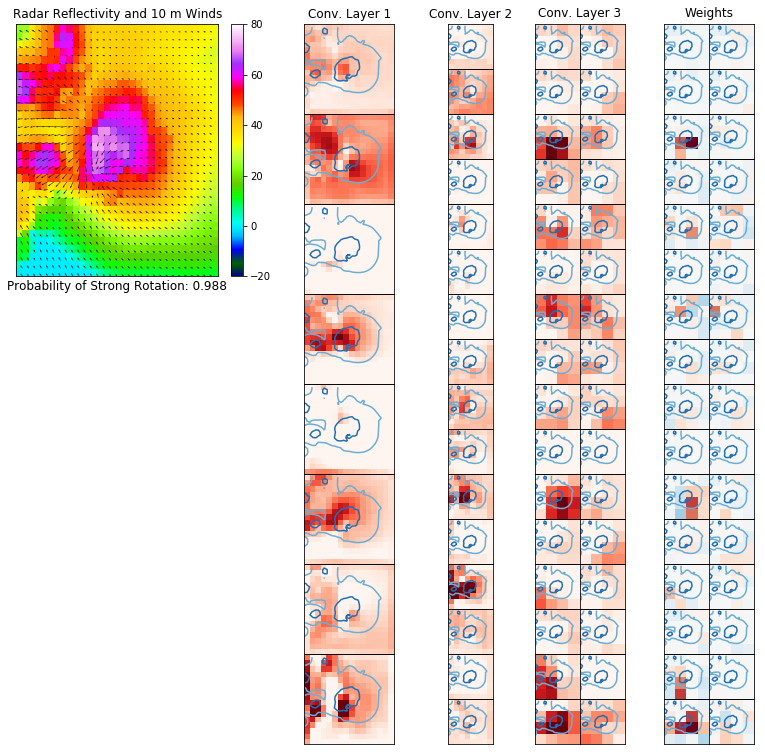

In [296]:
plot_conv_layers_out(32237)

We can generate maps of the gradients from the neural network. This will be described in more detail in module 4.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


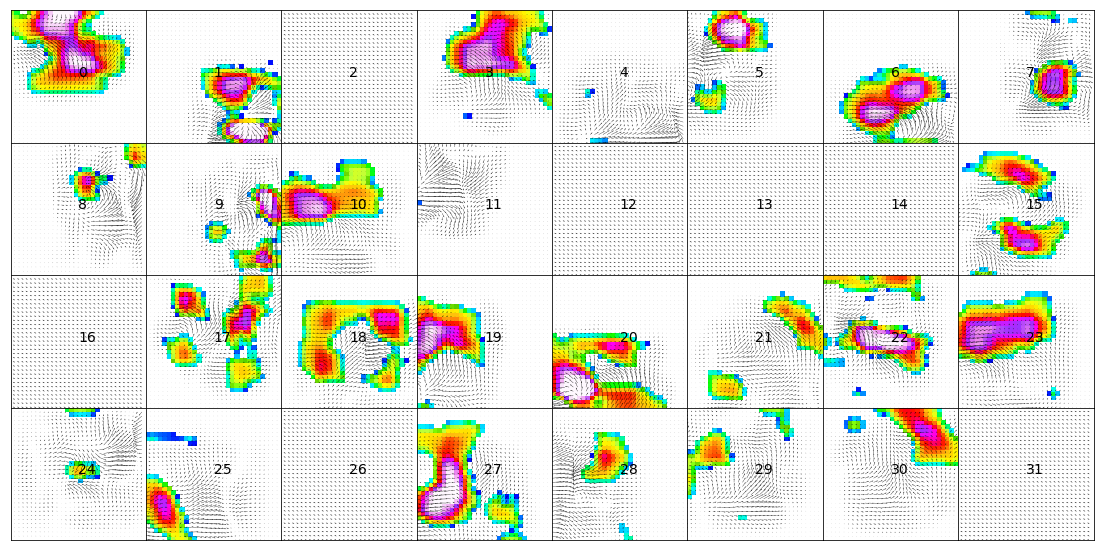

In [20]:
fig, axes = plt.subplots(4, 8, figsize=(16, 8), sharex=True, sharey=True)
plt.subplots_adjust(0.02, 0.02, 0.96, 0.94, wspace=0,hspace=0)
index = 28079
for conv_filter, ax in enumerate(axes.ravel()):
    print(conv_filter)
    out_diff = K.abs(K.max(conv_model.layers[-4].output[0, :, :, conv_filter]) - 1)
    grad = K.gradients(out_diff, [conv_model.input])[0]
    grad /= K.maximum(K.std(grad), K.epsilon())
    iterate = K.function([conv_model.input, K.learning_phase()], 
                             [out_diff, grad])
    input_img_data_neuron_grad = np.zeros((1, 32, 32, len(in_vars)))
    input_img_data_neuron = np.zeros((1, 32, 32, 3))
    #input_img_data_neuron = np.copy(test_norm_2d[index:index+1])    
    out_loss, out_grad = iterate([input_img_data_neuron, 1])
    input_img_data_neuron -= out_grad
    input_img_data_neuron[0, :, :, 0] = np.where(input_img_data_neuron[0, :, :, 0] < 0.5, -5, input_img_data_neuron[0, :, :, 0])
    grad_refl = gaussian_filter(input_img_data_neuron[0, :, :, 0], 1) * scaling_values.loc[0, "std"] + scaling_values.loc[0, "mean"]
    #ax.pcolormesh(input_img_data_neuron[0, :, :, 0], cmap="PuOr")
    #ax.contour(gaussian_filter(-out_grad[0, :, :, 0], 1), [-3, -2, -1, 1, 2, 3], vmin=-3, vmax=3, cmap="RdBu_r")
    ax.pcolormesh(np.ma.array(grad_refl, mask=grad_refl < 0), 
                   vmin=-10, vmax=80, cmap="gist_ncar")
    ax.quiver(gaussian_filter(input_img_data_neuron[0, :, :, -2], 1) * scaling_values.loc[1, "std"] + scaling_values.loc[1, "mean"], 
               gaussian_filter(input_img_data_neuron[0, :, :, -1], 1)* scaling_values.loc[2, "std"] + scaling_values.loc[2, "mean"],
               )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.text(16,16, conv_filter, fontsize=14)

12


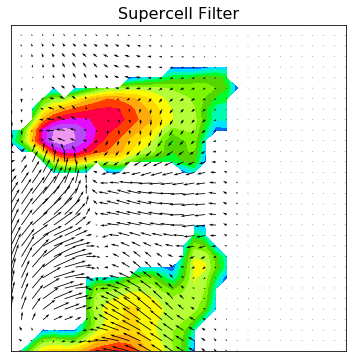

In [344]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
conv_filter = 12
print(conv_filter)
out_diff = K.abs(K.max(conv_model.layers[-4].output[0, :, :, conv_filter]) - 1)
grad = K.gradients(out_diff, [conv_model.input])[0]
grad /= K.maximum(K.std(grad), K.epsilon())
iterate = K.function([conv_model.input, K.learning_phase()], 
                         [out_diff, grad])
input_img_data_neuron_grad = np.zeros((1, 32, 32, len(in_vars)))
input_img_data_neuron = np.zeros((1, 32, 32, 3))
#input_img_data_neuron = np.copy(test_norm_2d[index:index+1])    
out_loss, out_grad = iterate([input_img_data_neuron, 1])
input_img_data_neuron -= out_grad
#ax.pcolormesh(input_img_data_neuron[0, :, :, 0], cmap="PuOr")
#ax.contour(gaussian_filter(-out_grad[0, :, :, 0], 1), [-3, -2, -1, 1, 2, 3], vmin=-3, vmax=3, cmap="RdBu_r")
input_img_data_neuron[0, :, :, 0] = np.where(input_img_data_neuron[0, :, :, 0] < 0.1, -5, input_img_data_neuron[0, :, :, 0])
grad_refl = gaussian_filter(input_img_data_neuron[0, :, :, 0], 1) * scaling_values.loc[0, "std"] + scaling_values.loc[0, "mean"]
ax.contourf(np.ma.array(grad_refl, mask=grad_refl < 0), np.arange(0, 85, 5),
               vmin=-10, vmax=80, cmap="gist_ncar", extend="max")
ax.quiver(gaussian_filter(input_img_data_neuron[0, :, :, -2], 1) * scaling_values.loc[1, "std"] + scaling_values.loc[1, "mean"], 
           gaussian_filter(input_img_data_neuron[0, :, :, -1], 1)* scaling_values.loc[2, "std"] + scaling_values.loc[2, "mean"],
           )
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Supercell Filter", fontsize=16)
plt.savefig("supercell_filter.png", dpi=200, bbox_inches="tight")

30


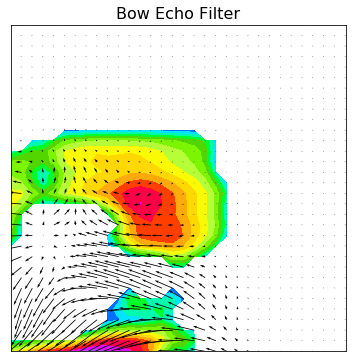

In [345]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
conv_filter = 30
print(conv_filter)
out_diff = K.abs(K.max(conv_model.layers[-4].output[0, :, :, conv_filter]) - 1)
grad = K.gradients(out_diff, [conv_model.input])[0]
grad /= K.maximum(K.std(grad), K.epsilon())
iterate = K.function([conv_model.input, K.learning_phase()], 
                         [out_diff, grad])
input_img_data_neuron_grad = np.zeros((1, 32, 32, len(in_vars)))
input_img_data_neuron = np.zeros((1, 32, 32, 3))
#input_img_data_neuron = np.copy(test_norm_2d[index:index+1])    
out_loss, out_grad = iterate([input_img_data_neuron, 1])
input_img_data_neuron -= out_grad
#ax.pcolormesh(input_img_data_neuron[0, :, :, 0], cmap="PuOr")
#ax.contour(gaussian_filter(-out_grad[0, :, :, 0], 1), [-3, -2, -1, 1, 2, 3], vmin=-3, vmax=3, cmap="RdBu_r")
input_img_data_neuron[0, :, :, 0] = np.where(input_img_data_neuron[0, :, :, 0] < 0.1, -5, input_img_data_neuron[0, :, :, 0])
grad_refl = gaussian_filter(input_img_data_neuron[0, :, :, 0], 1) * scaling_values.loc[0, "std"] + scaling_values.loc[0, "mean"]
ax.contourf(np.ma.array(grad_refl, mask=grad_refl < 0), np.arange(0, 85, 5),
               vmin=-10, vmax=80, cmap="gist_ncar", extend="max")
ax.quiver(gaussian_filter(input_img_data_neuron[0, :, :, -2], 1) * scaling_values.loc[1, "std"] + scaling_values.loc[1, "mean"], 
           gaussian_filter(input_img_data_neuron[0, :, :, -1], 1)* scaling_values.loc[2, "std"] + scaling_values.loc[2, "mean"],
           )
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Bow Echo Filter", fontsize=16)
plt.savefig("bow_echo_filter.png", dpi=200, bbox_inches="tight")

We can also generate saliency maps for individual examples.

0
1
2
3


/opt/conda/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


Text(0.5, 0.98, 'Final Convolution Filter Saliency Maps')

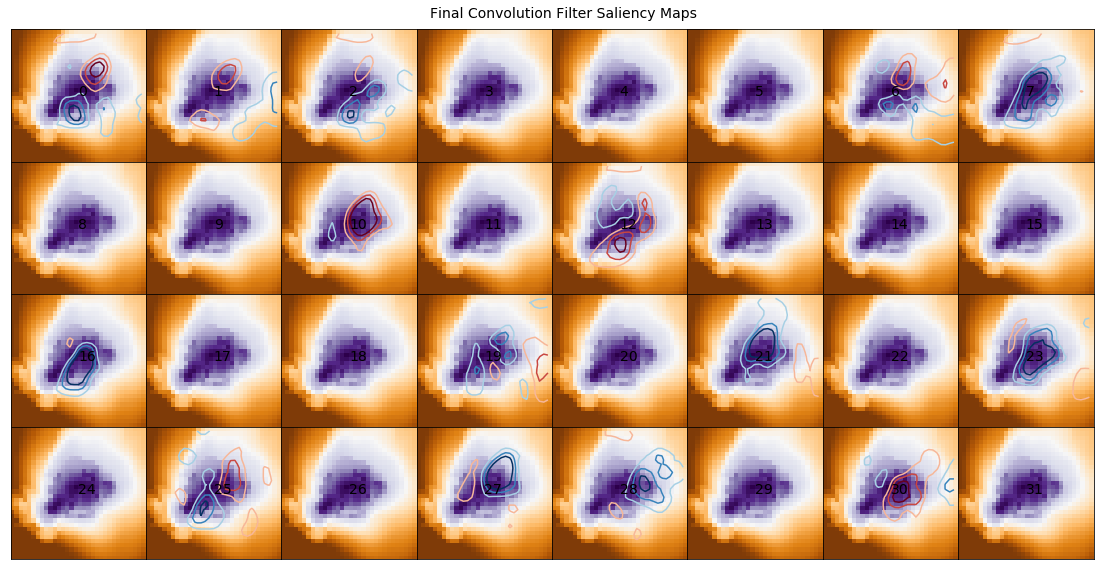

In [21]:
fig, axes = plt.subplots(4, 8, figsize=(16, 8), sharex=True, sharey=True)
plt.subplots_adjust(0.02, 0.02, 0.96, 0.94, wspace=0,hspace=0)
index = 28079
for conv_filter, ax in enumerate(axes.ravel()):
    print(conv_filter)
    out_diff = K.abs(conv_model.layers[-4].output[0, 2, 2, conv_filter] - 1)
    grad = K.gradients(out_diff, [conv_model.input])[0]
    grad /= K.maximum(K.std(grad), K.epsilon())
    iterate = K.function([conv_model.input, K.learning_phase()], 
                             [out_diff, grad])
    input_img_data_neuron_grad = np.zeros((1, 32, 32, len(in_vars)))
    input_img_data_neuron = np.copy(test_norm_2d[index:index+1])    
    out_loss, out_grad = iterate([input_img_data_neuron, 1])
    ax.pcolormesh(input_img_data_neuron[0, :, :, 0], cmap="PuOr")
    ax.contour(gaussian_filter(-out_grad[0, :, :, 0], 1), [-3, -2, -1, 1, 2, 3], vmin=-3, vmax=3, cmap="RdBu_r")
    #ax.pcolormesh(input_img_data_neuron[0, :, :, 0] * scaling_values.loc[0, "std"] + scaling_values.loc[0, "mean"], 
    #               vmin=-10, vmax=80, cmap="gist_ncar")
    #ax.quiver(input_img_data_neuron[0, :, :, -2]* scaling_values.loc[1, "std"] + scaling_values.loc[1, "mean"], 
    #           input_img_data_neuron[0, :, :, -1]* scaling_values.loc[2, "std"] + scaling_values.loc[2, "mean"],
    #           scale=100)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.text(16,16, conv_filter, fontsize=14)
plt.suptitle("Final Convolution Filter Saliency Maps", fontsize=14, y=0.98)

## Regularization
With large numbers of weights to fit, and limited amounts of data for which to do so, neural networks can easily overfit to noise in the dataset if they are not constrained properly. While the use of convolutions and pooling does act as a regularizer, additional regularization techniques may be necessary for networks with many weights. We will discuss two common regularization techniques: weight decay and dropout.

### Weight Decay
![ridge](http://www.astroml.org/_images/fig_lasso_ridge_1.png)
Weight decay is a way to constrain the weights of a regression model by including a penalty term in the loss function that minimizes the total magnitude of the weights. The penalty term's affect is modulated by a parameter $\alpha$. There are two common forms of weight decay, Ridge (or L2 norm, Tikhonov) and LASSO (or L1 norm) regularization. Ridge regularization reduces the magnitudes of all weights by a constant factor, but more relevant weights are less affected, and less relevant weights are minimized. LASSO regularization reduces less relevant weights to 0, resulting in a sparse set of weights. LASSO can be used as a form of feature selection.

We will now train a CNN with Ridge regularization on the weights. This is done in Keras by adding a `kernel_regularizer=l2(l2_param)` argument to each Conv2D and Dense layer. 

In [21]:
num_conv_filters = 8
filter_width = 5
conv_activation = "relu"
learning_rate = 0.001
l2_param = 0.001
# Input data in shape (instance, y, x, variable)
conv_net_in_l2 = Input(shape=train_norm_2d.shape[1:])
# First 2D convolution Layer
conv_net_l2 = Conv2D(num_conv_filters, (filter_width, filter_width), padding="same",
                     kernel_regularizer=l2(l2_param))(conv_net_in_l2)
conv_net_l2 = Activation(conv_activation)(conv_net_l2)
# Average pooling takes the mean in a 2x2 neighborhood to reduce the image size
conv_net_l2 = AveragePooling2D()(conv_net_l2)
# Second set of convolution and pooling layers
conv_net_l2 = Conv2D(num_conv_filters * 2, (filter_width, filter_width), padding="same",
                     kernel_regularizer=l2(l2_param))(conv_net_l2)
conv_net_l2 = Activation(conv_activation)(conv_net_l2)
conv_net_l2 = AveragePooling2D()(conv_net_l2)
# Third set of convolution and pooling layers
conv_net_l2 = Conv2D(num_conv_filters * 4, (filter_width, filter_width), padding="same",
                     kernel_regularizer=l2(l2_param))(conv_net_l2)
conv_net_l2 = Activation(conv_activation)(conv_net_l2)
conv_net_l2 = AveragePooling2D()(conv_net_l2)
# Flatten the last convolutional layer into a long feature vector
conv_net_l2 = Flatten()(conv_net_l2)
# Dense output layer, equivalent to a logistic regression on the last layer
conv_net_l2 = Dense(1, kernel_regularizer=l2(l2_param))(conv_net_l2)
conv_net_l2 = Activation("sigmoid")(conv_net_l2)
conv_model_l2 = Model(conv_net_in_l2, conv_net_l2)
# Use the Adam optimizer with default parameters
opt = Adam(lr=learning_rate)
conv_model_l2.compile(opt, "binary_crossentropy")

In [22]:
conv_model_l2.fit(train_norm_2d, train_out, batch_size=512, epochs=10)

Epoch 1/5
76377/76377 [==============================] - 5s 60us/step - loss: 0.2110
Epoch 2/5
76377/76377 [==============================] - 4s 50us/step - loss: 0.1555
Epoch 3/5
76377/76377 [==============================] - 4s 51us/step - loss: 0.1344
Epoch 4/5
76377/76377 [==============================] - 4s 50us/step - loss: 0.1248
Epoch 5/5
76377/76377 [==============================] - 4s 50us/step - loss: 0.1213


In [23]:
calc_verification_scores(conv_model_l2, test_norm_2d, test_out)

AUC: 0.949
Brier Score: 0.031
Brier Score (Climatology): 0.050
Brier Skill Score: 0.380


### Dropout
Dropout is a regularization technique that enables one to train an arbitrary ensemble of small models while only storing one model. Procedurally dropout is straightforward. A Dropout layer is assigned a probability of dropout. Each time the layer is called, each input to the layer is randomly set to 0 based on the dropout probability. For a dropout rate of 0.5, there is a 50% chance that a given neuron will be set to 0. For a given call, around 50% of the neurons will be set to zero, but there will be some variation. In order to maintain the same mean as the full model, the remaining inputs are divided by the dropout rate. Because certain neurons are not always available during training, dropout encourages independence among neurons during training.

The default dropout procedure is to drop individual neurons randomly. For convolutional neural networks with spatially-correlated data, standard dropout may not have a large effect on the results, so a variation called SpatialDropout2D is available. Instead of dropping out individual neurons, it drops whole channels randomly.

Dropout can also be used during inference to produce estimates of prediction uncertainty. If one sends the same example through the network many times with dropout activated, then a distribution of predictions will be produced. There is evidence that this distribution is well-calibrated, but adjusting the dropout rate may be necessary to produce the most reliable prediction intervals.

Below is an example of dropout and spatial dropout on a field of ones. Run the second cell multiple times to see how the dropout results vary.

In [24]:
drop_in = K.placeholder((1, 10, 10, 3))
dropout_rate = 0.5
drop = Dropout(dropout_rate)(drop_in)
spatial_dropout = SpatialDropout2D(dropout_rate)(drop_in)
drop_func = K.function([drop_in, K.learning_phase()], [drop, spatial_dropout])


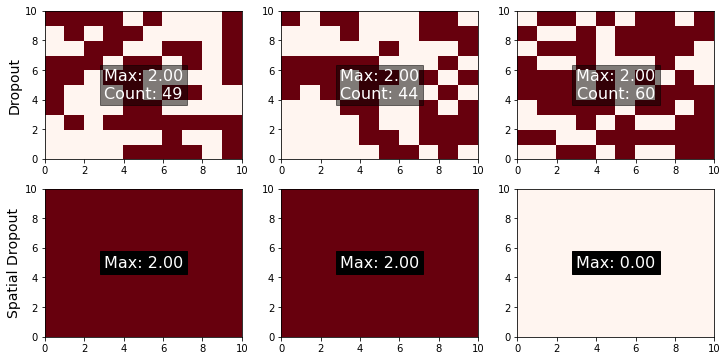

In [25]:
input_field = np.ones((1, 10, 10, 3))
drop_output, space_drop_output = drop_func([input_field, 1])
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes[0, 0].set_ylabel("Dropout", fontsize=14)
axes[1, 0].set_ylabel("Spatial Dropout", fontsize=14)
for a in range(3):
    axes[0, a].pcolormesh(drop_output[0, :, :, a], vmin=0, vmax=2, cmap="Reds")
    axes[0, a].text(5, 5, f"Max: {drop_output[0, :, :, a].max():0.2f}\nCount: {np.count_nonzero(drop_output[0, :, :, a]):d}", ha='center', va='center', fontsize=16, color='white',
                    bbox=dict(facecolor='k', alpha=0.5))
    axes[1, a].pcolormesh(space_drop_output[0, :, :, a], vmin=0, vmax=2, cmap="Reds")
    axes[1, a].text(5, 5, f"Max: {space_drop_output[0, :, :, a].max():0.2f}", ha='center', va='center', fontsize=16, color='white',
                    bbox=dict(facecolor='k'))



We will now build a convolutional neural network with spatial dropout layers.

In [26]:
num_conv_filters = 16
filter_width = 5
conv_activation = "relu"
learning_rate = 0.001
dropout_rate = 0.2
# Input data in shape (instance, y, x, variable)
conv_net_in_d = Input(shape=train_norm_2d.shape[1:])
# First 2D convolution Layer
conv_net_d = Conv2D(num_conv_filters, (filter_width, filter_width), padding="same")(conv_net_in_d)
conv_net_d = Activation(conv_activation)(conv_net_d)
conv_net_d = SpatialDropout2D(dropout_rate)(conv_net_d)
# Average pooling takes the mean in a 2x2 neighborhood to reduce the image size
conv_net_d = AveragePooling2D()(conv_net_d)
# Second set of convolution and pooling layers
conv_net_d = Conv2D(num_conv_filters * 2, (filter_width, filter_width), padding="same")(conv_net_d)
conv_net_d = Activation(conv_activation)(conv_net_d)
conv_net_d = SpatialDropout2D(dropout_rate)(conv_net_d)
conv_net_d = AveragePooling2D()(conv_net_d)
# Third set of convolution and pooling layers
conv_net_d = Conv2D(num_conv_filters * 4, (filter_width, filter_width), padding="same")(conv_net_d)
conv_net_d = Activation(conv_activation)(conv_net_d)
conv_net_d = SpatialDropout2D(dropout_rate)(conv_net_d)
conv_net_d = AveragePooling2D()(conv_net_d)
# Flatten the last convolutional layer into a long feature vector
conv_net_d = Flatten()(conv_net_d)
# Dense output layer, equivalent to a logistic regression on the last layer
conv_net_d = Dense(1)(conv_net_d)
conv_net_d = Activation("sigmoid")(conv_net_d)
conv_model_d = Model(conv_net_in_d, conv_net_d)
# Use the Adam optimizer with default parameters
opt = Adam(lr=learning_rate)
conv_model_d.compile(opt, "binary_crossentropy")

In [27]:
conv_model_d.fit(train_norm_2d, train_out, batch_size=512, epochs=10)

Epoch 1/10
76377/76377 [==============================] - 7s 94us/step - loss: 0.1804
Epoch 2/10
76377/76377 [==============================] - 6s 82us/step - loss: 0.1398
Epoch 3/10
76377/76377 [==============================] - 6s 80us/step - loss: 0.1266
Epoch 4/10
76377/76377 [==============================] - 6s 81us/step - loss: 0.1191
Epoch 5/10
76377/76377 [==============================] - 6s 80us/step - loss: 0.1134
Epoch 6/10
76377/76377 [==============================] - 6s 80us/step - loss: 0.1102
Epoch 7/10
76377/76377 [==============================] - 6s 80us/step - loss: 0.1072
Epoch 8/10
76377/76377 [==============================] - 6s 80us/step - loss: 0.1043
Epoch 9/10
76377/76377 [==============================] - 6s 80us/step - loss: 0.1036
Epoch 10/10
76377/76377 [==============================] - 6s 81us/step - loss: 0.1013


Did the verification scores improve?

In [28]:
calc_verification_scores(conv_model_d, test_norm_2d, test_out)

AUC: 0.959
Brier Score: 0.028
Brier Score (Climatology): 0.050
Brier Skill Score: 0.439


Finally we will use the dropout layers in inference mode to generate distributions of predictions. How does the uncertainty change with different examples?

In [29]:
dist_pred = K.function([conv_model_d.input, K.learning_phase()], [conv_model_d.output])

Text(0, 0.5, 'Frequency')

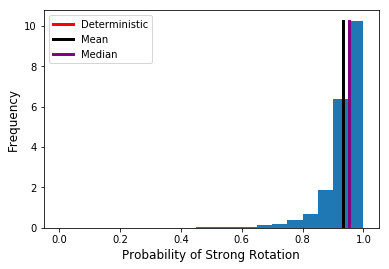

In [30]:
num_samples = 1000
index = 32237
pred_values = np.zeros(num_samples)
pred_det = conv_model_d.predict(test_norm_2d[index:index+1])[0, 0]
for i in range(num_samples):
    pred_values[i] = dist_pred([test_norm_2d[index:index+1], 1])[0][0,0]
freqs, bins, patches = plt.hist(pred_values, bins=np.arange(0, 1.05, 0.05), cumulative=False, density=True)
plt.plot([pred_det, pred_det], [0, freqs.max()], 'r-', lw=3, label="Deterministic")
plt.plot([pred_values.mean(), pred_values.mean()], [0, freqs.max()], 'k-', lw=3, label="Mean")
plt.plot([np.median(pred_values), np.median(pred_values)], [0, freqs.max()], color='purple', lw=3, label="Median")
plt.legend()
plt.xlabel("Probability of Strong Rotation", fontsize=12)
plt.ylabel("Frequency", fontsize=12)